# Cluster Analysis Course Notebook

### Importing Data files

In [7]:
# The code was removed by Watson Studio for sharing.

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [8]:
#Import Transaction DataSet here
body = client_1db92c7017d54886831046b32d9ea878.get_object(Bucket='project1-donotdelete-pr-fak4pf0yfksumo',Key='Transaction Data Set - Student 3 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

transactions_data = pd.read_csv(body,sep='|')
transactions_data.head()


,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [9]:
#Import Customer Dataset Here
body = client_1db92c7017d54886831046b32d9ea878.get_object(Bucket='project1-donotdelete-pr-fak4pf0yfksumo',Key='Customer Data Set - Student 1 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customer_data = pd.read_csv(body)
customer_data.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing data types

In [10]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [11]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [12]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [13]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [14]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [15]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [16]:
customer_prod_categ=customer_prod_categ.reset_index()

In [17]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [18]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [19]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [20]:
customer_KPIs=customer_KPIs.fillna(0)


In [21]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [22]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Clustering  

In [23]:
#Begin Writing your code here
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

cluster_input=customer_all_view[['INCOME', 'TOTAL SPENT']]
cluster_input.head(5)

,INCOME,TOTAL SPENT
0,133498,6826.770
1,94475,5062.451
2,88610,8562.440
3,84313,5522.694
4,51498,213.512


In [41]:
Kmeans_model=KMeans(n_clusters=4)
Kmeans_model
cluster_output = Kmeans_model.fit_predict(cluster_input)
cluster_output
type(cluster_output)
product_data.head()
product_data.head().values
product_data.head().values[1,2]
product_data.head().values[1,:]
product_data.head().values[:,2]
cluster_output_pd=pd.DataFrame(cluster_output,columns=['segment'])
cluster_output_pd.head()
segment_DF=pd.concat([cluster_input,cluster_output_pd],axis=1)
segment_DF.head()
Kmeans_model.cluster_centers_
segment_DF[segment_DF.segment==0].head()

,INCOME,TOTAL SPENT,segment
7,115672,8412.001,0
8,101741,9116.576,0
11,101805,293.100,0
17,112035,4242.889,0
20,105964,5957.315,0


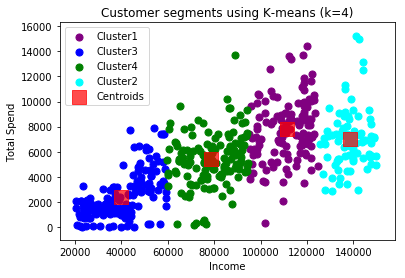

In [46]:
import matplotlib.pyplot as plt
plt.scatter(segment_DF[segment_DF.segment==0]['INCOME'],segment_DF[segment_DF.segment==0]['TOTAL SPENT'],s=50, c='purple',label='Cluster1')
plt.scatter(segment_DF[segment_DF.segment==1]['INCOME'],segment_DF[segment_DF.segment==1]['TOTAL SPENT'],s=50, c='blue',label='Cluster3')
plt.scatter(segment_DF[segment_DF.segment==2]['INCOME'],segment_DF[segment_DF.segment==2]['TOTAL SPENT'],s=50, c='green',label='Cluster4')
plt.scatter(segment_DF[segment_DF.segment==3]['INCOME'],segment_DF[segment_DF.segment==3]['TOTAL SPENT'],s=50, c='cyan',label='Cluster2')
plt.scatter(Kmeans_model.cluster_centers_[:,0], Kmeans_model.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Customer segments using K-means (k=4)')
plt.xlabel('Income')
plt.ylabel('Total Spend')
plt.legend()
plt.show()
plt.show()


In [47]:
customer_demographics=pd.concat([customer_all_view,cluster_output_pd],axis=1)
customer_demographics.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT,segment
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770,3
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451,2
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440,2
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694,2
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512,1


In [48]:
customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median'})

,AGE,HOUSEHOLD SIZE
segment,,
0,47.841270,3
1,24.932886,2
2,36.311594,3
3,73.609195,2


In [49]:
def percent_loyalty(series):
    percent=100 * series.value_counts()['enrolled'] /series.count()
    return percent

In [50]:
customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median','LOYALTY GROUP': percent_loyalty})

,AGE,HOUSEHOLD SIZE,LOYALTY GROUP
segment,,,
0,47.841270,3,67.460317
1,24.932886,2,50.335570
2,36.311594,3,34.057971
3,73.609195,2,65.517241
